## Quora Question Pair Similarity

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import spacy

In [2]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [3]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [4]:
#df[df.isna().any(axis=1)]

## Distribution of Data points among output classes

<AxesSubplot:xlabel='is_duplicate'>

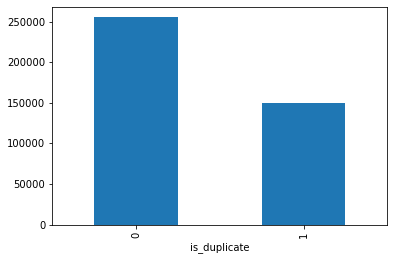

In [5]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [6]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


## Number of Unique Question:

In [7]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
print('Number of questions repeated:{}\n'.format(qs_morethan_onetime))

Total number of  Unique Questions are: 537933

Number of questions repeated:111780



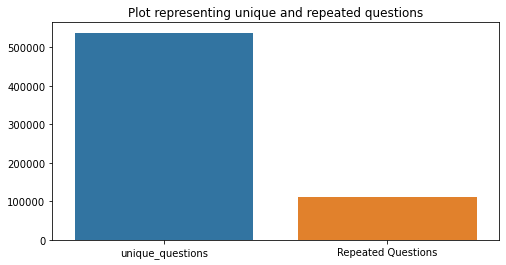

In [8]:
x = ["unique_questions" , "Repeated Questions"]
y = [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(8, 4))
plt.title ("Plot representing unique and repeated questions")
sns.barplot(x,y)
plt.show()

## Checking the Duplicates:

In [9]:
pair_duplicates=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


## Number of occurance of question:

Maximum number of times a single question is repeated: 157



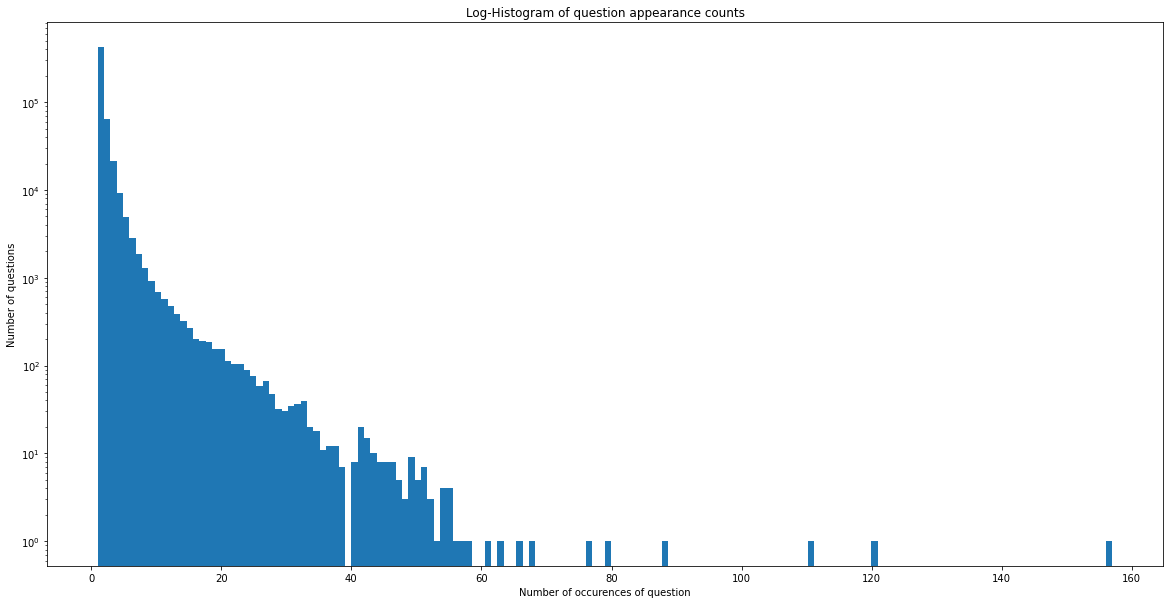

In [10]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

## Checking on Null Values:

In [11]:
df.isna().sum()


id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [12]:
# Filling the null values with '
df.dropna(inplace=True)
df.isna().sum()


id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

## Basic Feature Extraction:

In [13]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len']=df['question1'].str.len()
df['q2len']=df['question2'].str.len()
df['q1_n_words']=df['question1'].apply(lambda x: len(x.split(' ')))
df['q2_n_words']=df['question2'].apply(lambda x: len(x.split(' ')))

In [14]:
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)
def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])


In [15]:
#df.head()

## Analysis of extracted features:

In [16]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


### Feature: Word_share

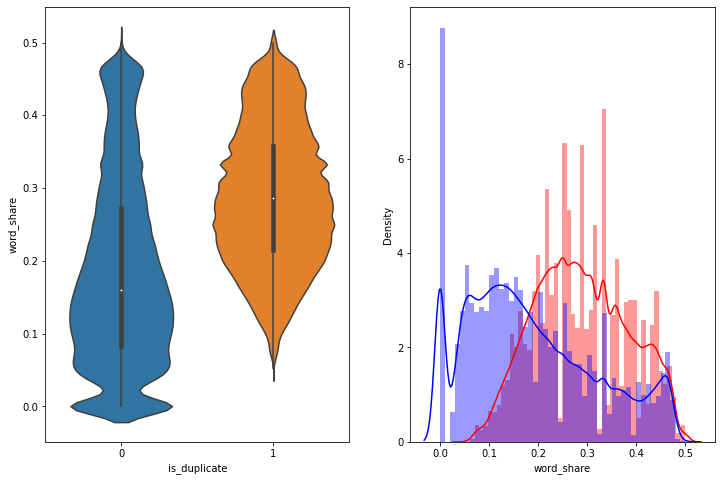

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

### Feature: Word_common

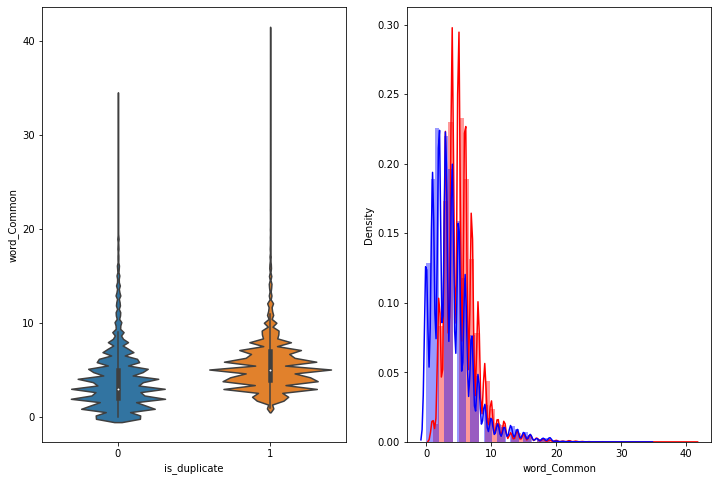

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'] , label = "0" , color = 'blue' )
plt.show()

### Text Preprocessing:

In [19]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

### Token Features

In [20]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [21]:
df = extract_features(df)
df.head(2)

token features...
fuzzy features..


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate  freq_qid1  \
0  what is the step by step guide to invest in sh...             0          1   
1  what would happen if the indian government sto...             0          4   

   freq_qid2  q1len  q2len  ...   ctc_max  last_word_eq  first_word_eq  \
0          1     66     57  ...  0.785709           0.0            1.0   
1          1     51     88  ...  0.466664           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   
1           5.0      12.5               86                63          66   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759  
1                  75              0.596154  

[2 rows x 32 columns]

In [22]:
df.shape

(404287, 32)

## Visualisation of Extracted Feature:
### Ploting Word Cloud:

In [23]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

textp_qs = pd.Series(df_duplicate['question1'].tolist() + df_duplicate['question2'].tolist()).astype(str)

textn_qs = pd.Series(dfp_nonduplicate['question1'].tolist() + dfp_nonduplicate['question2'].tolist()).astype(str)

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510048


In [24]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193130


Word Cloud for Duplicate Question pairs


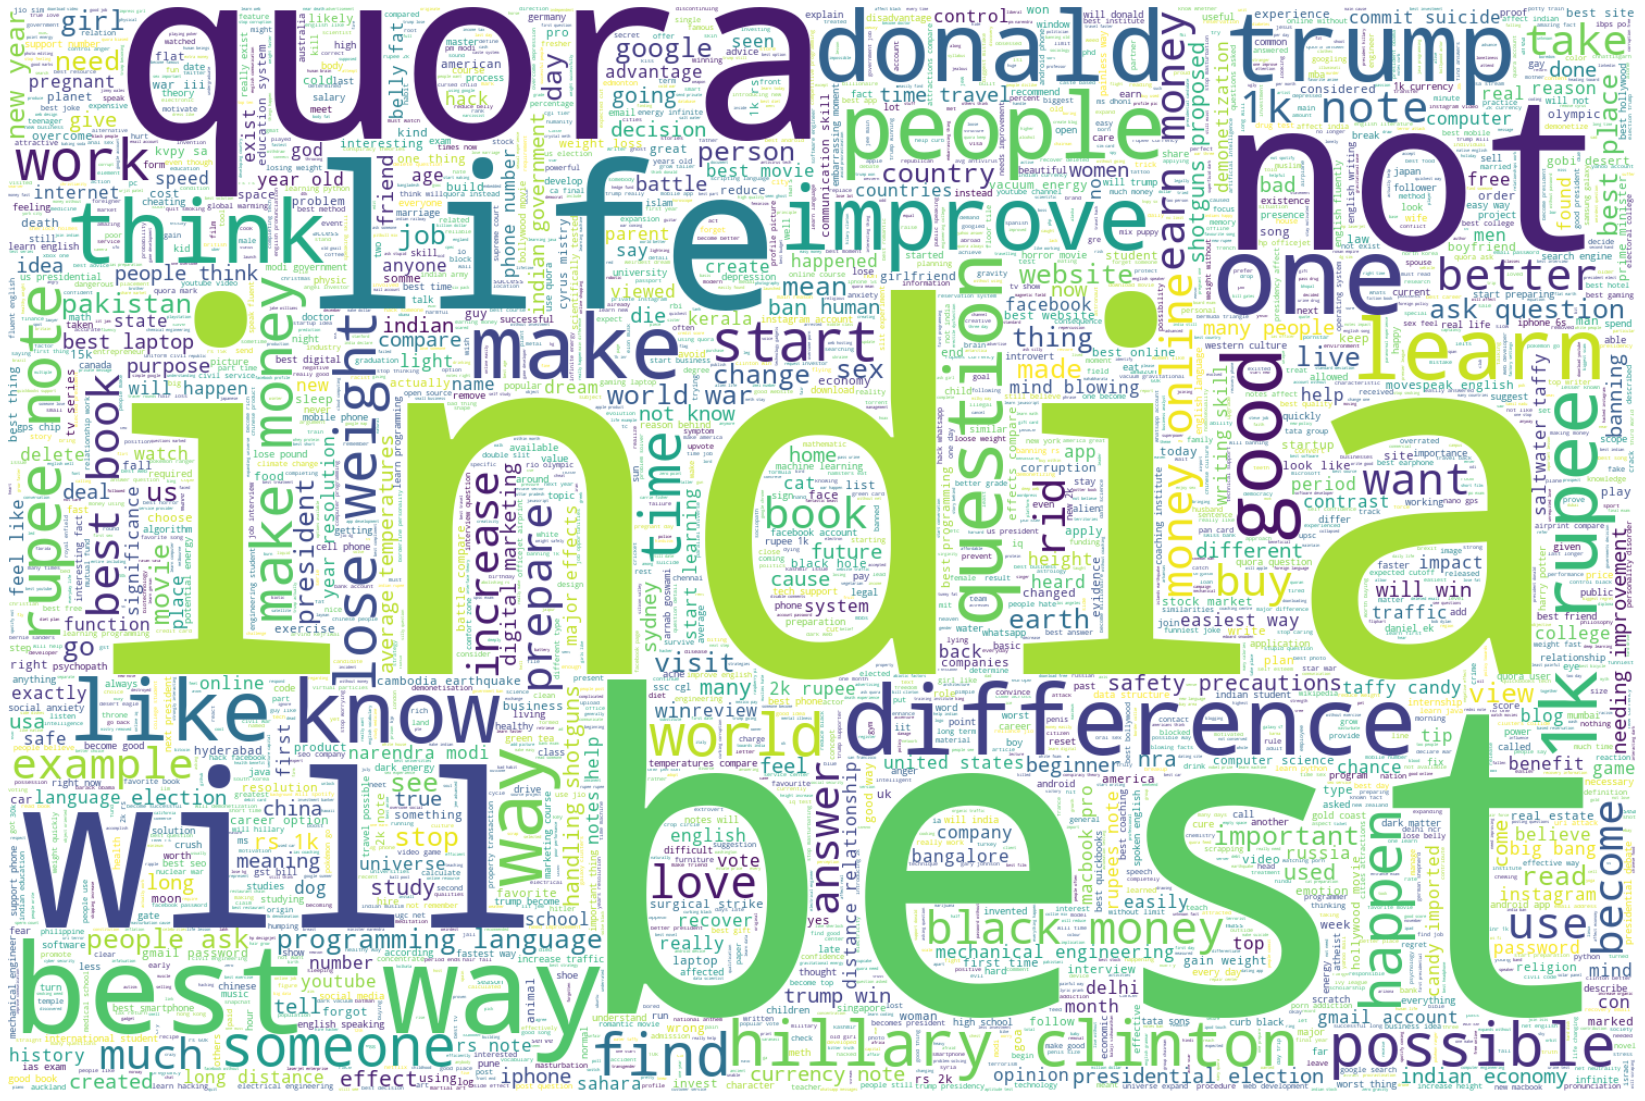

In [25]:
wc = WordCloud(background_color="white",width=1500,height=1000 ,max_words=len(textp_qs), stopwords=stopwords)
wc.generate(" ".join(textp_qs.astype(str)))
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(30,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Duplicate Question pairs


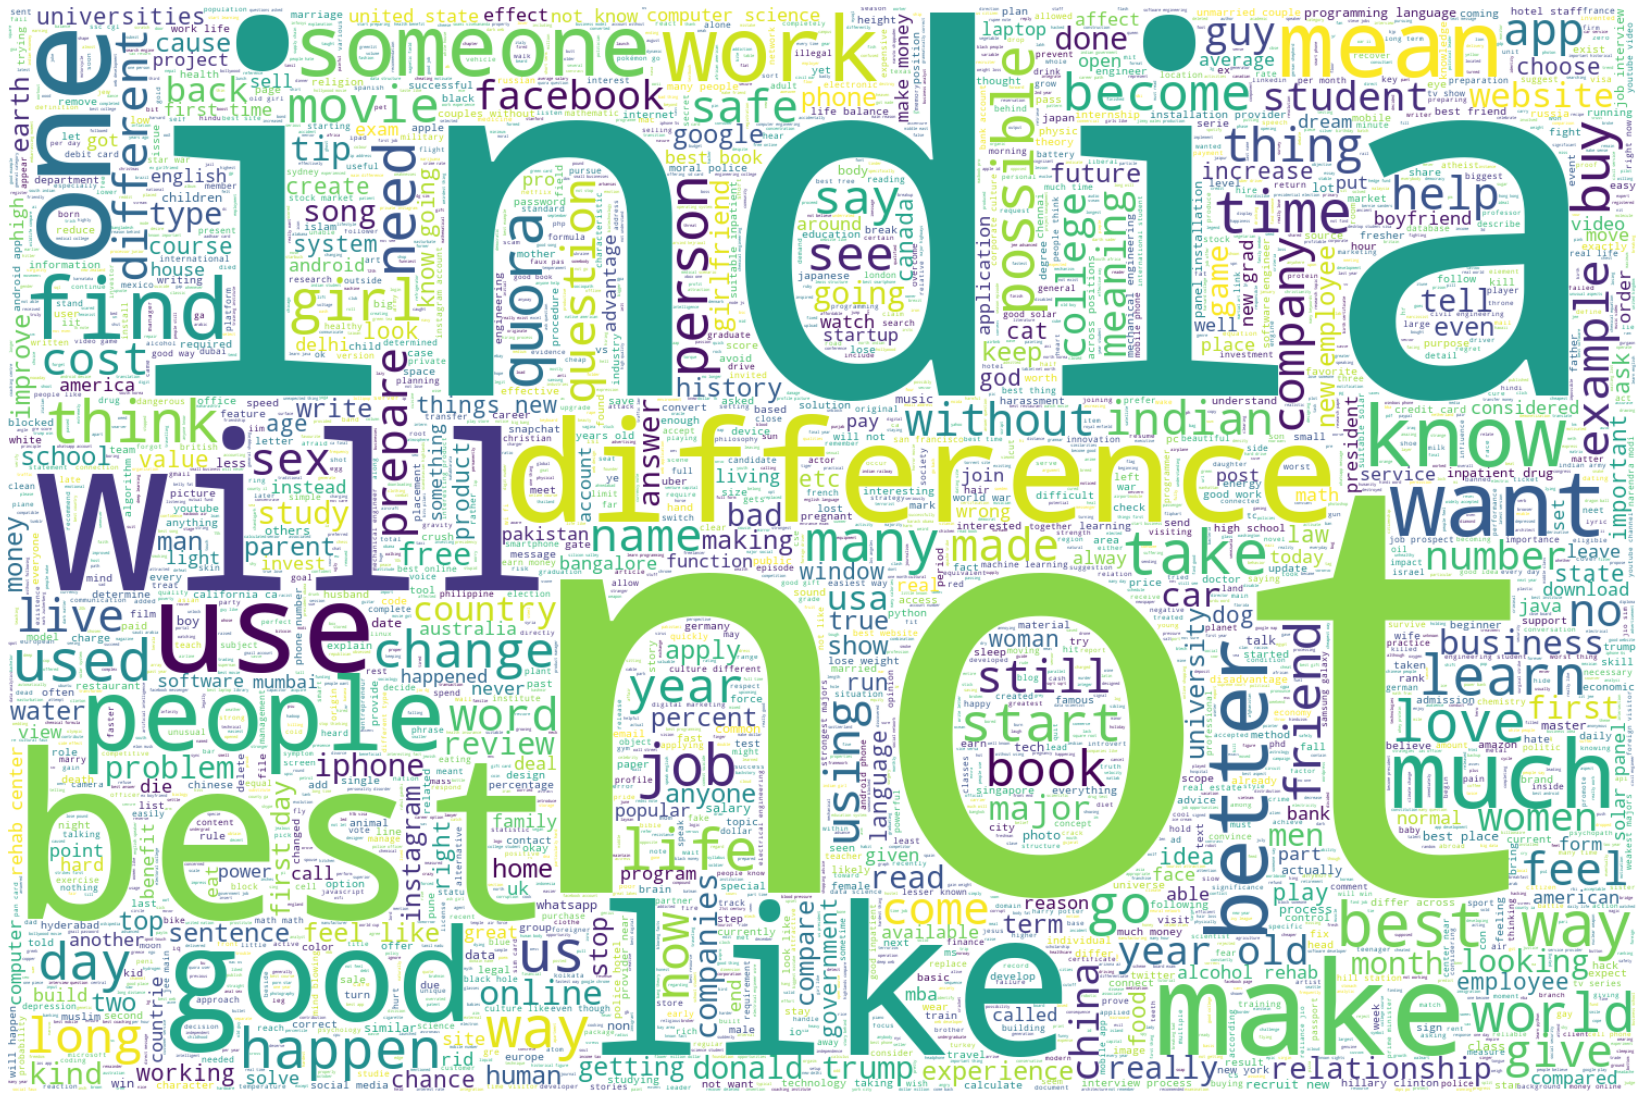

In [26]:
wc = WordCloud(background_color="white",width=1500,height=1000 ,max_words=len(textp_qs), stopwords=stopwords)
wc.generate(" ".join(textn_qs.astype(str)))
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(30,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>


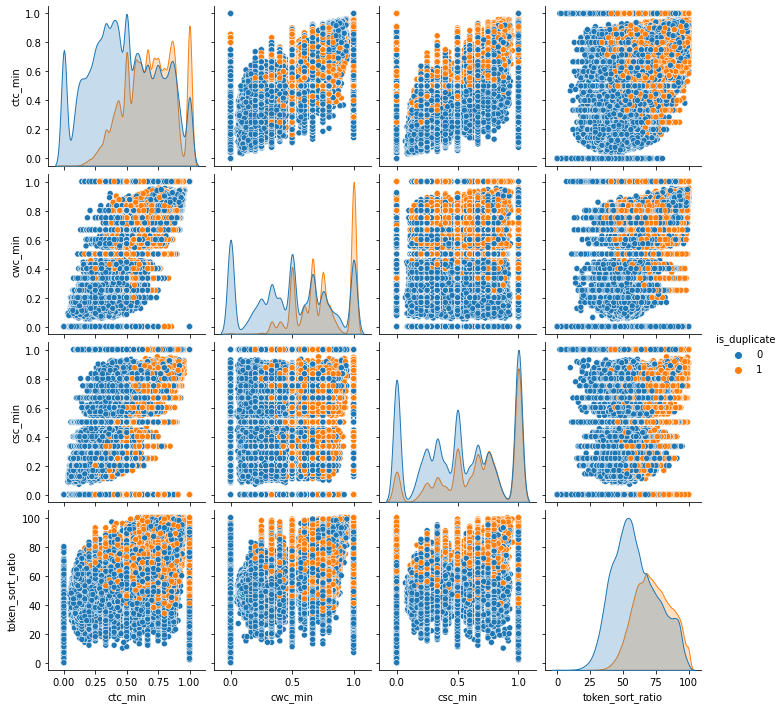

In [27]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

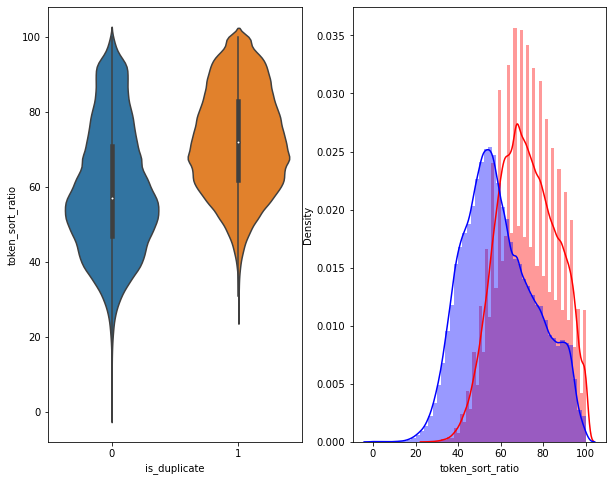

In [28]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

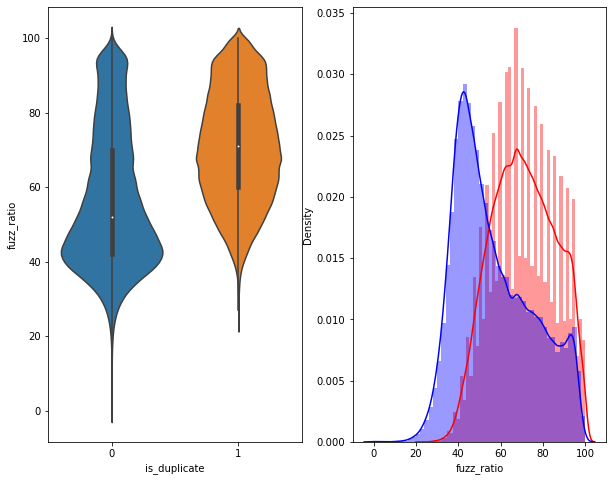

In [29]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

### Visualization:

In [30]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [31]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.037s...
[t-SNE] Computed neighbors for 5000 samples in 0.387s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.216s
[t-SNE] Iteration 50: error = 80.9733734, gradient norm = 0.0451379 (50 iterations in 1.610s)
[t-SNE] Iteration 100: error = 70.4407959, gradient norm = 0.0098959 (50 iterations in 1.476s)
[t-SNE] Iteration 150: error = 68.6497803, gradient norm = 0.0059423 (50 iterations in 1.729s)
[t-SNE] Iteration 200: error = 67.8067017, gradient norm = 0.0040715 (50 iterations in 1.669s)
[t-SNE] Iteration 250: error = 67.3086243, gradient norm = 0.0031636

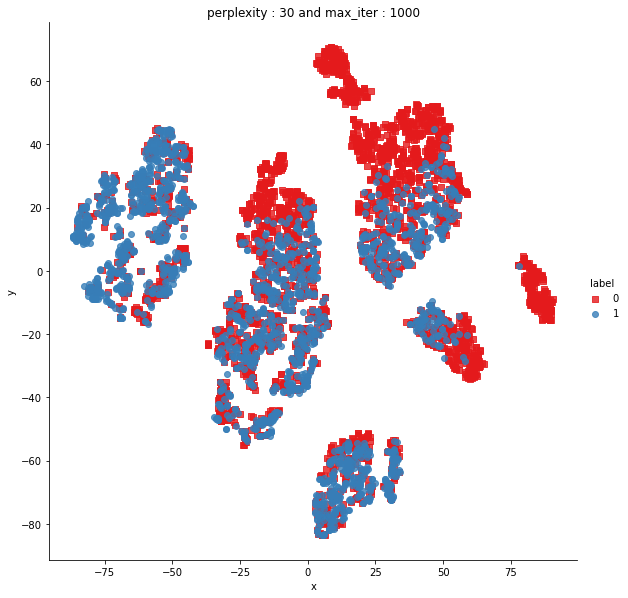

In [32]:
df1 = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df1, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [33]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.026s...
[t-SNE] Computed neighbors for 5000 samples in 0.367s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.202s
[t-SNE] Iteration 50: error = 80.3930130, gradient norm = 0.0316218 (50 iterations in 4.163s)
[t-SNE] Iteration 100: error = 69.1391754, gradient norm = 0.0033516 (50 iterations in 2.871s)
[t-SNE] Iteration 150: error = 67.6481857, gradient norm = 0.0017935 (50 iterations in 3.333s)
[t-SNE] Iteration 200: error = 67.0898132, gradient norm = 0.0012118 (50 iterations in 2.918s)
[t-SNE] Iteration 250: error = 66.7632446, gradient norm = 0.0008854

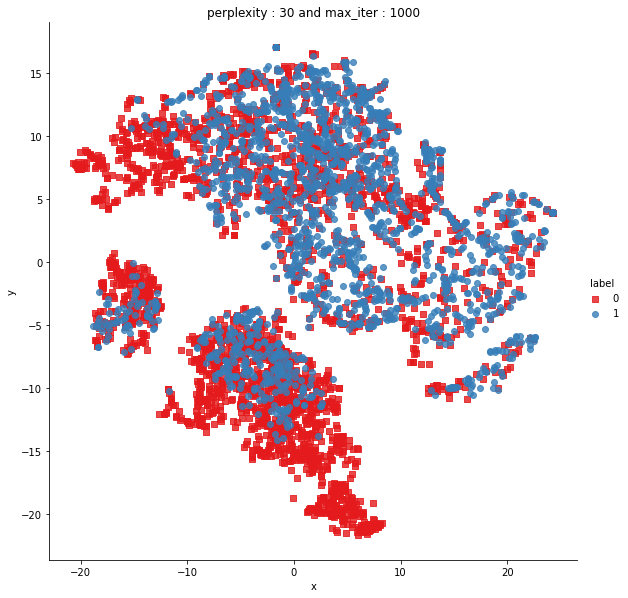

In [34]:
df2 = pd.DataFrame({'x':tsne3d[:,0], 'y':tsne3d[:,2] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df2, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [35]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

### Splitting of Data:

In [36]:
df.drop(df[df['question1'].astype(bool)==False].index, inplace=True)
df.drop(df[df['question2'].astype(bool)==False].index, inplace=True)

In [37]:
df[df['question2'] == False].value_counts()

Series([], dtype: int64)

In [38]:
y_true=df['is_duplicate']

In [39]:
df[df['question2'].astype(bool)==False].index


Int64Index([], dtype='int64')

In [40]:
df.shape

(404269, 32)

In [41]:
y_true.isnull().sum()

0

In [42]:
df['question1'].astype(bool).value_counts()


True    404269
Name: question1, dtype: int64

In [43]:
#df.drop(df[df['question1'] == False].index, inplace=True)

In [44]:
df['question1'].astype(bool).value_counts()


True    404269
Name: question1, dtype: int64

In [45]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

In [46]:
print("The shape of train",X_train.shape,y_train.shape)
print("The shape of test",X_test.shape,y_test.shape)

The shape of train (282988, 32) (282988,)
The shape of test (121281, 32) (121281,)


## Applying TFIDFW2Vec :


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions_train = list(X_train['question1']) + list(X_train['question2'])

tfidf_train = TfidfVectorizer(lowercase=False, )
tfidf_train.fit_transform(questions_train)

# # dict key:word and value:tf-idf score
word2tfidf_train = dict(zip(tfidf_train.get_feature_names(), tfidf_train.idf_))

In [48]:
#df[df['question1']=='']

In [49]:
############################ Using SpaCy  #################################
import en_core_web_sm
# en_vectors_web_lg, which includes over 1 million unique vectors.
#nlp = spacy.load('en_core_web_sm')
nlp=en_core_web_sm.load()
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q1_feats_m'] = list(vecs1)

100%|██████████| 282988/282988 [54:07<00:00, 87.15it/s]    


In [50]:
vecs2 = []
for qu2 in tqdm(list(X_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_train['q2_feats_m'] = list(vecs2)

100%|██████████| 282988/282988 [36:30<00:00, 129.18it/s]


In [51]:
#X_train.shape

In [52]:
X_train.isnull().values.any()

False

In [53]:
X_train_q1 = pd.DataFrame(X_train.q1_feats_m.values.tolist(), index= X_train.index)
X_train_q2 = pd.DataFrame(X_train.q2_feats_m.values.tolist(), index= X_train.index)

In [54]:
X_train.drop(['q1_feats_m','q2_feats_m'],axis=1)

id    qid1    qid2  \
165724  165724  257283  257284   
383878  383878  188004  308885   
166018  166018  257686   89836   
81162    81162  109191  137856   
223626  223626  331488  331489   
...        ...     ...     ...   
388867  388867  521312  179883   
252706  252706  367084  367085   
305833  305833    8254  141154   
369412  369412   88042  363394   
142498  142498   17161  225971   

                                                question1  \
165724    who designed the first structure of a building    
383878           what is the business model of littleapp    
166018                      what are some good ya novels    
81162   what is the property tax rate in granville  oh...   
223626  what are some good courses that i can take on ...   
...                                                   ...   
388867  how can one behave different with different pe...   
252706  what is some alternate slogans for the clinton...   
305833  how long will it take for meth to get out of m...   
369412  i want to live the rest of my life alone and w...   
142498                  what do afghans think of indians    

                                                question2  is_duplicate  \
165724  who designed the first shell structure of a bu...             0   
383878               what is the business model of dunzo              0   
166018               what are some really good ya novels              1   
81162   what is the property tax rate in granville  oh...             0   
223626  what advantages do i have if i do a course fro...             0   
...                                                   ...           ...   
388867  does everyone behaves differently with differe...             0   
252706  spi has advantages making it theoretically ver...             0   
305833         how do i get meth out of my system faster              1   
369412  how do i accept that i will live alone the res...             0   
142498   what do afghans think of the song afghan jalebi              0   

        freq_qid1  freq_qid2  q1len  q2len  ...   ctc_max  last_word_eq  \
165724          1          1     47     53  ...  0.888879           1.0   
383878          2          2     40     36  ...  0.857131           0.0   
166018          1          2     29     36  ...  0.857131           1.0   
81162          13          2     94     96  ...  0.833329           0.0   
223626          1          1     81    113  ...  0.260868           0.0   
...           ...        ...    ...    ...  ...       ...           ...   
388867          1          1     51     56  ...  0.374995           1.0   
252706          1          1     55    149  ...  0.111111           0.0   
305833          2         12     91     42  ...  0.333332           0.0   
369412         18          2     92     59  ...  0.444442           0.0   
142498          2          1     33     48  ...  0.555549           0.0   

        first_word_eq  abs_len_diff  mean_len  token_set_ratio  \
165724            1.0           1.0       8.5              100   
383878            1.0           0.0       7.0               91   
166018            1.0           1.0       6.5              100   
81162             1.0           0.0      18.0               93   
223626            1.0           8.0      19.0               59   
...               ...           ...       ...              ...   
388867            0.0           1.0       7.5               76   
252706            0.0          18.0      18.0               41   
305833            1.0          14.0      17.0               86   
369412            0.0           4.0      16.0               73   
142498            1.0           3.0       7.5               86   

        token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  longest_substr_ratio  
165724                94          94                  87              0.520833  
383878                78          81                  83              0.810811  
166018                89        

In [55]:
X_train_q1['id']=X_train['id']
X_train_q2['id']=X_train['id']
df1  = X_train_q1.merge(X_train_q2, on='id',how='left')
X_train  = X_train.merge(df1, on='id',how='left')

In [56]:
X_train.shape

(282988, 226)

### TFIDF vectorization on test data:

In [57]:
X_test['question1'].isnull().values.any()

False

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions_test = list(X_test['question1']) + list(X_test['question2'])

# tfidf_train = TfidfVectorizer(lowercase=False, )
tfidf_train.transform(questions_test)

# # dict key:word and value:tf-idf score
word2tfidf_test = dict(zip(tfidf_train.get_feature_names(), tfidf_train.idf_))

In [59]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_test[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q1_feats_m'] = list(vecs1)

100%|██████████| 121281/121281 [17:13<00:00, 117.31it/s]


In [60]:
vecs2 = []
for qu2 in tqdm(list(X_test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf_test[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_test['q2_feats_m'] = list(vecs2)

100%|██████████| 121281/121281 [16:10<00:00, 125.02it/s]


In [61]:
X_test_q1 = pd.DataFrame(X_test.q1_feats_m.values.tolist(), index= X_test.index)
X_test_q2 = pd.DataFrame(X_test.q2_feats_m.values.tolist(), index= X_test.index)

In [62]:
X_test.drop(['q1_feats_m','q2_feats_m'],axis=1)                                              

id    qid1    qid2  \
268257  268257  113956  167781   
189685  189685   91468  288511   
68503    68503  118365  118366   
309466  309466  433449  433450   
310538  310538  434667  434668   
...        ...     ...     ...   
320076  320076  445579   49768   
38544    38544   69982   69983   
220898  220898  328108  121520   
274952  274952   27713  211210   
106020  106020  174717  174718   

                                                question1  \
268257  which was the best porn video you have ever se...   
189685  what is the easiest way to get followers on qu...   
68503                what is the chabad view on lesbians    
309466  why did donald trump tweet   are we living in ...   
310538  what is the intuition behind the  potential  f...   
...                                                   ...   
320076         what are some movies with the most nudity    
38544   how credible is the national enquirer when it ...   
220898                    where can i find the happiness    
274952            does masturbation cause loss of memory    
106020  how do i get physiotherapy diploma equivalence...   

                                                question2  is_duplicate  \
268257  what are some best porn videos you have came a...             1   
189685  how does one get  followers on quora without p...             0   
68503                      are there any indian lesbians              0   
309466  what kind of mobile phone does donald trump tw...             0   
310538  how the infix to postfix algorithm came to be ...             0   
...                                                   ...           ...   
320076  what are some of the biggest mistakes or incon...             0   
38544   what evidence does the national enquirer have ...             1   
220898                      where can one find happiness              1   
274952               does masturbation cause memory loss              1   
106020  how can i study for free  and eventually get a...             0   

        freq_qid1  freq_qid2  q1len  q2len  ...   ctc_max  last_word_eq  \
268257          2          1     76     50  ...  0.249998           0.0   
189685          5          2     50     62  ...  0.399996           0.0   
68503           1          1     35     30  ...  0.142855           1.0   
309466          2          1     60     53  ...  0.272725           0.0   
310538          1          1     94     78  ...  0.399997           0.0   
...           ...        ...    ...    ...  ...       ...           ...   
320076          2          3     42     90  ...  0.312498           0.0   
38544           2          1     81     90  ...  0.266665           0.0   
220898          2          1     31     29  ...  0.666656           1.0   
274952          2          1     39     36  ...  0.833319           0.0   
106020          2          1     69     55  ...  0.454541           0.0   

        first_word_eq  abs_len_diff  mean_len  token_set_ratio  \
268257            0.0           6.0      13.0               66   
189685            0.0           0.0      10.0               66   
68503             0.0           2.0       6.0               59   
309466            0.0           1.0      10.5               63   
310538            0.0           1.0      14.5               72   
...               ...           ...       ...              ...   
320076            1.0           8.0      12.0               74   
38544             0.0           2.0      14.0               64   
220898            1.0           1.0       5.5               92   
274952            1.0           1.0       5.5              100   
106020            1.0           0.0      11.0               61   

        token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  longest_substr_ratio  
268257                56          59                  69              0.320755  
189685                61          53                  60              0.392157  
68503                 56        

In [63]:
X_test_q1['id']=X_test['id']
X_test_q2['id']=X_test['id']
df_test  = X_test_q1.merge(X_test_q2, on='id',how='left')
X_test  = X_test.merge(df_test, on='id',how='left')

In [64]:
X_test.shape

(121281, 226)

In [65]:
X_test.isnull().values.any()

False

##

In [66]:
X_test.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       ...
       '86_y', '87_y', '88_y', '89_y', '90_y', '91_y', '92_y', '93_y', '94_y',
       '95_y'],
      dtype='object', length=226)

In [67]:
X_train = X_train.drop(['id','question1','question2','q1_feats_m','q2_feats_m','qid1','qid2','is_duplicate'],axis=1)
# X_train.drop(X_train.index[0], inplace=True)
X_test = X_test.drop(['id','question1','question2','q1_feats_m','q2_feats_m','qid1','qid2','is_duplicate'],axis=1)
# X_test.drop(X_test.index[0], inplace=True)

In [68]:
X_train.shape,X_test.shape

((282988, 218), (121281, 218))

## Applying Models:

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [70]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (282988, 218)
Number of data points in test data : (121281, 218)


In [71]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6307829307249777 Class 1:  0.36921706927502224
---------- Distribution of output variable in train data ----------
Class 0:  0.36921694247244 Class 1:  0.36921694247244


In [72]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Model Training:

Log loss on Test Data using Random Model 0.8854006077801032


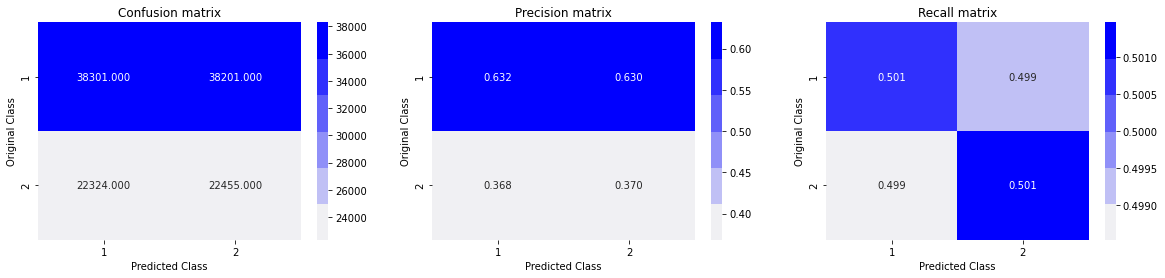

In [73]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## Logistic Regression:

For values of alpha =  1e-05 The log loss is: 0.45239327342216584
For values of alpha =  0.0001 The log loss is: 0.45624166997552396
For values of alpha =  0.001 The log loss is: 0.4720874165412406
For values of alpha =  0.01 The log loss is: 0.4316507261269247
For values of alpha =  0.1 The log loss is: 0.4503087176129156
For values of alpha =  1 The log loss is: 0.47967836527065444
For values of alpha =  10 The log loss is: 0.528684078063948


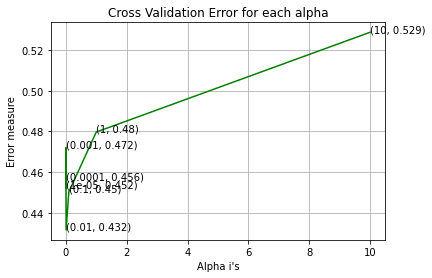

For values of best alpha =  0.01 The train log loss is: 0.4294825437906755
For values of best alpha =  0.01 The test log loss is: 0.4316507261269247
Total number of data points : 121281


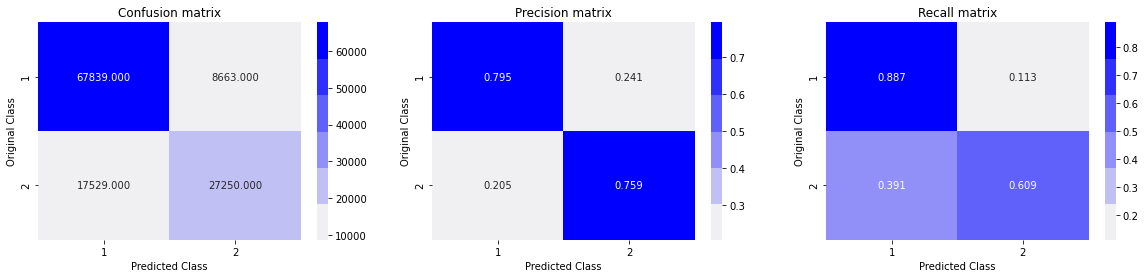

In [74]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Linear SVM:

For values of alpha =  1e-05 The log loss is: 0.6585376086950245
For values of alpha =  0.0001 The log loss is: 0.6585376086950245
For values of alpha =  0.001 The log loss is: 0.5804814446721531
For values of alpha =  0.01 The log loss is: 0.49237879582628863
For values of alpha =  0.1 The log loss is: 0.5541410659834707
For values of alpha =  1 The log loss is: 0.5940066520498818
For values of alpha =  10 The log loss is: 0.6585376086950245


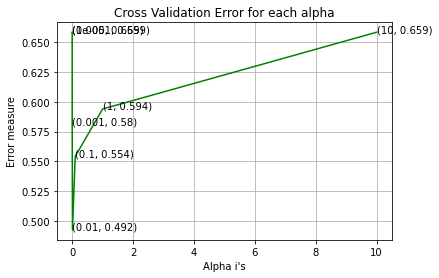

For values of best alpha =  0.01 The train log loss is: 0.48951063787739874
For values of best alpha =  0.01 The test log loss is: 0.49237879582628863
Total number of data points : 121281


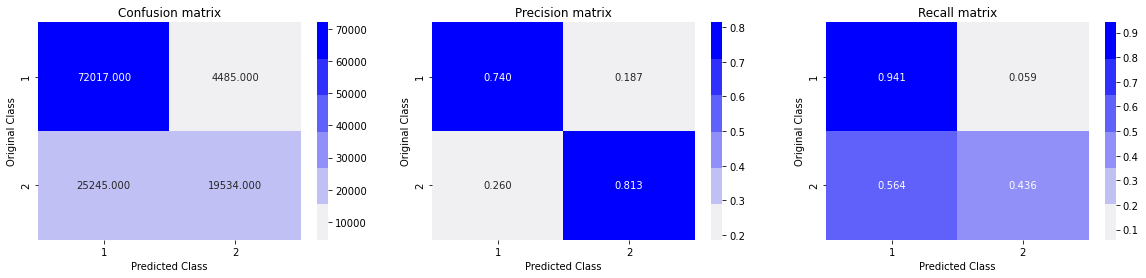

In [79]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [77]:
#Refer :https://lightgbm.readthedocs.io/en/latest/Python-Intro.html
#Refer:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lxgb
params = {      
    'max_depth': [3, 4, 5, 6, 7, 8],       
    'eta' : [0.01, 0.02, 0.05, 0.1]    
}

lightxgb = lxgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced')
random_search = RandomizedSearchCV(lightxgb, param_distributions=params, scoring='neg_log_loss',return_train_score=True,cv=3) 
final_random=random_search.fit(X_train, y_train)

print("best parameters from randomsearch :",final_random.best_params_)

print("best score from randomsearch :",final_random.best_score_)


best parameters from randomsearch : {'max_depth': 8, 'eta': 0.1}
best score from randomsearch : -0.3492124623205816


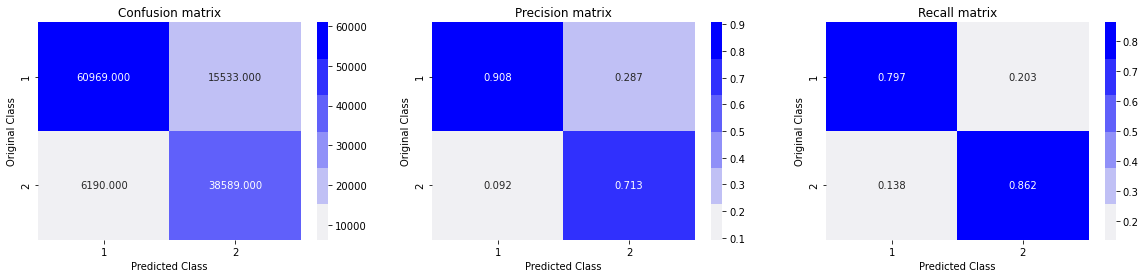

In [78]:
# applying xgboost using optimal parameters
optimal_xgb = lxgb.LGBMClassifier(boosting_type='gbdt',ets=0.1, max_depth= 8, class_weight='balanced')

optimal_xgb.fit(X_train,y_train)
predicted_y= optimal_xgb.predict(X_test)
plot_confusion_matrix(y_test,predicted_y)